In [11]:
# If you see errors, make sure your VS Code Jupyter kernel is set to your venv!
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from app.embeddings import get_embedding  # uses your all-MiniLM-L6-v2 model

In [12]:
DB_PATH = 'data/resume_screening.db'

def get_resume_texts():
    conn = sqlite3.connect(DB_PATH)
    c = conn.cursor()
    c.execute("SELECT resume_id, name, education, skills, experience FROM resumes")
    rows = c.fetchall()
    conn.close()
    names = []
    texts = []
    for row in rows:
        resume_id, name, education, skills, experience = row
        text = f"Education: {education}\nSkills: {skills}\nExperience: {experience}"
        names.append(name if name else f"Resume {resume_id}")
        texts.append(text)
    return names, texts

def get_jd_texts():
    conn = sqlite3.connect(DB_PATH)
    c = conn.cursor()
    c.execute("SELECT jd_id, jd_job_title, jd_responsibilities, jd_req_education, jd_req_skill, jd_req_experience FROM jds")
    rows = c.fetchall()
    conn.close()
    names = []
    texts = []
    for row in rows:
        jd_id, title, resp, edu, skill, exp = row
        text = f"Title: {title}\nResponsibilities: {resp}\nEducation: {edu}\nSkills: {skill}\nExperience: {exp}"
        names.append(title if title else f"JD {jd_id}")
        texts.append(text)
    return names, texts


In [13]:
# This may take a minute if you have many records!
resume_names, resume_texts = get_resume_texts()
jd_names, jd_texts = get_jd_texts()

print(f"Found {len(resume_names)} resumes and {len(jd_names)} JDs.")

resume_embs = np.array([get_embedding(text) for text in resume_texts])
jd_embs = np.array([get_embedding(text) for text in jd_texts])


Found 16 resumes and 6 JDs.


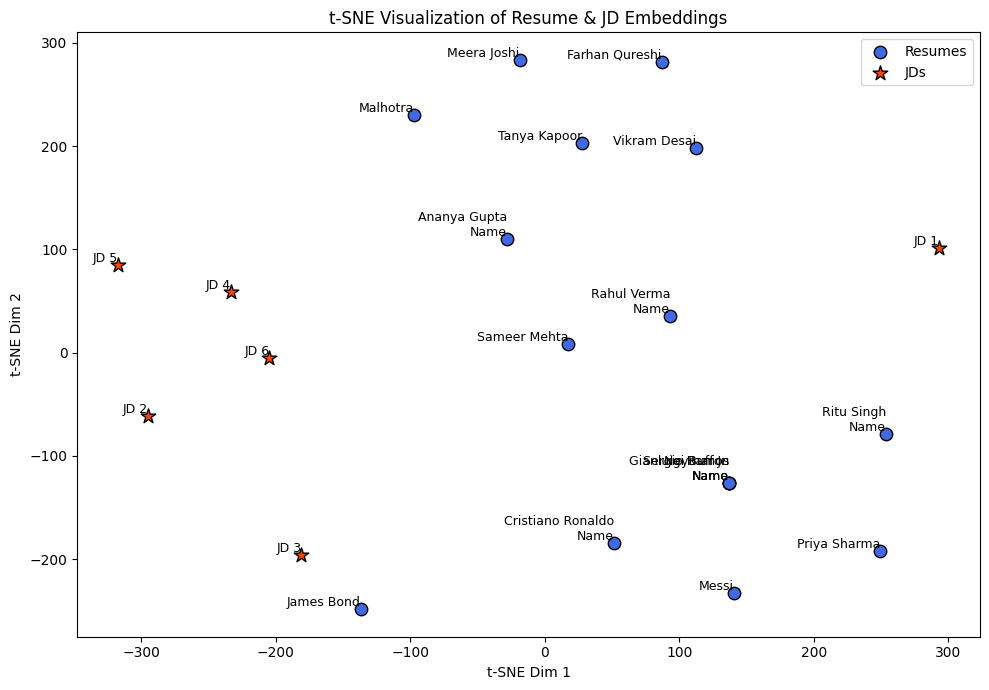

In [14]:
def plot_tsne(resume_names, resume_embs, jd_names, jd_embs, perplexity=10, random_state=42):
    all_names = list(resume_names) + list(jd_names)
    all_embs = np.vstack([resume_embs, jd_embs])
    labels = [0] * len(resume_names) + [1] * len(jd_names)

    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_state)
    reduced = tsne.fit_transform(all_embs)

    plt.figure(figsize=(10, 7))
    plt.scatter(
        reduced[:len(resume_names), 0], reduced[:len(resume_names), 1],
        c='royalblue', label='Resumes', s=80, edgecolors='k'
    )
    plt.scatter(
        reduced[len(resume_names):, 0], reduced[len(resume_names):, 1],
        c='orangered', label='JDs', s=120, marker='*', edgecolors='k'
    )
    for i, name in enumerate(all_names):
        plt.text(reduced[i, 0], reduced[i, 1], name, fontsize=9, ha='right', va='bottom')
    plt.title("t-SNE Visualization of Resume & JD Embeddings")
    plt.xlabel("t-SNE Dim 1")
    plt.ylabel("t-SNE Dim 2")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_tsne(resume_names, resume_embs, jd_names, jd_embs)
